## Purpose
Developing a model which can detect fraudulent bank transactions and therefore flag the transaction/account for review. Made using synthetic data!

## Content

Data for the case is available in CSV format having 6362620 rows and 10 columns.

Data Dictionary:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [75]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import BaseEstimator
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
import scipy.stats as stats
from sklearn.metrics import roc_curve
import sklearn.metrics
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


In [76]:
plt.style.use('ggplot')

In [77]:
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

## Inspection

In [78]:
df = pd.read_csv('data/fraud.csv')

In [79]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [80]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [81]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [83]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [84]:
print(f'{(df.isFraud.value_counts()[1]/df.isFraud.value_counts()[0])*100} percentage of transactions are fraudulent')

0.129248881917699 percentage of transactions are fraudulent


In [85]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## Clean

In [86]:
df['oldbalanceOrig'] = df['oldbalanceOrg']
df.drop(columns='oldbalanceOrg',inplace=True)

## Odd naming,changing it

In [87]:
df

,step,type,amount,nameOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,oldbalanceOrig
0,1,PAYMENT,9839.64,C1231006815,160296.36,M1979787155,0.00,0.00,0,0,170136.00
1,1,PAYMENT,1864.28,C1666544295,19384.72,M2044282225,0.00,0.00,0,0,21249.00
2,1,TRANSFER,181.00,C1305486145,0.00,C553264065,0.00,0.00,1,0,181.00
3,1,CASH_OUT,181.00,C840083671,0.00,C38997010,21182.00,0.00,1,0,181.00
4,1,PAYMENT,11668.14,C2048537720,29885.86,M1230701703,0.00,0.00,0,0,41554.00
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,0.00,C776919290,0.00,339682.13,1,0,339682.13
6362616,743,TRANSFER,6311409.28,C1529008245,0.00,C1881841831,0.00,0.00,1,0,6311409.28
6362617,743,CASH_OUT,6311409.28,C1162922333,0.00,C1365125890,68488.84,6379898.11,1,0,6311409.28
6362618,743,TRANSFER,850002.52,C1685995037,0.00,C2080388513,0.00,0.00,1,0,850002.52


In [88]:
df['typeDest'] = df['nameDest'].str[0] # Get's type, C for customer, M for Merchant
df['typeOrig'] = df['nameOrig'].str[0]

In [89]:
df.drop(columns=(['nameDest','nameOrig']),inplace=True) ## Do not need account numbers now that we have the type

In [90]:
df['typeOrig'].unique()

array(['C'], dtype=object)

In [91]:
df.drop(columns='typeOrig',inplace=True) ## Only one value, so drop it

In [92]:
# Turn hours passed since first transaction into hour of day
df['hour'] = df['step']%24

In [93]:
df.drop(columns='step',inplace=True) # Do not need hours passed since start anymore

In [94]:
df.drop(columns='isFlaggedFraud',inplace=True)

## WE DO NOT WANT TO SEE THE PREVIUS ML'S PREDICTION

## Vizualise

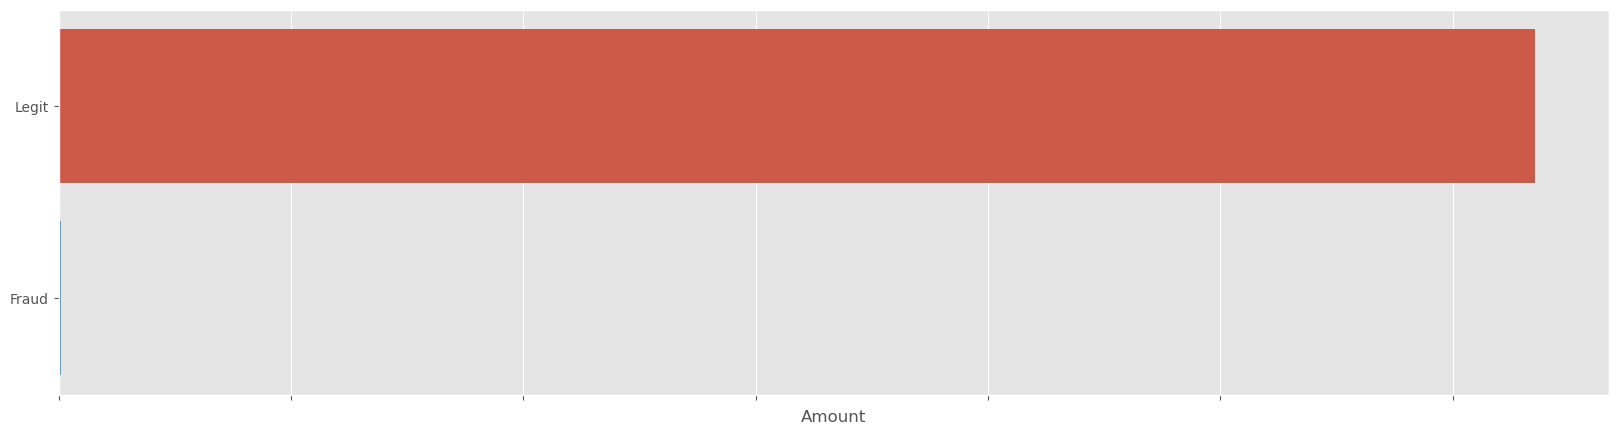

In [95]:
plt.figure(figsize=(20,5))
k=sns.barplot(y=df['isFraud'].value_counts().index,x=df['isFraud'].value_counts().values,orient='h')
k.set_yticklabels(['Legit','Fraud'])
k.set(xlabel='Amount')
plt.ticklabel_format(style='plain', axis='x')
k.set(xticklabels=[])
plt.show()

<AxesSubplot:xlabel='hour', ylabel='Count'>

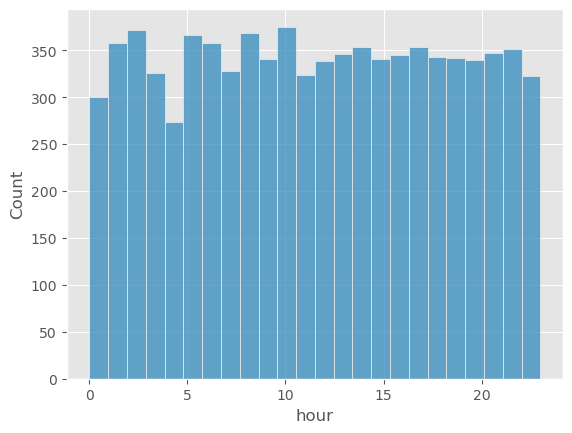

In [96]:
sns.histplot(df.loc[df['isFraud'] == 1]['hour'],bins=24)

In [97]:
sns.histplot(df.loc[df['isFraud'] != 1]['hour'],bins=24)

KeyboardInterrupt: 

<AxesSubplot:xlabel='type', ylabel='Count'>

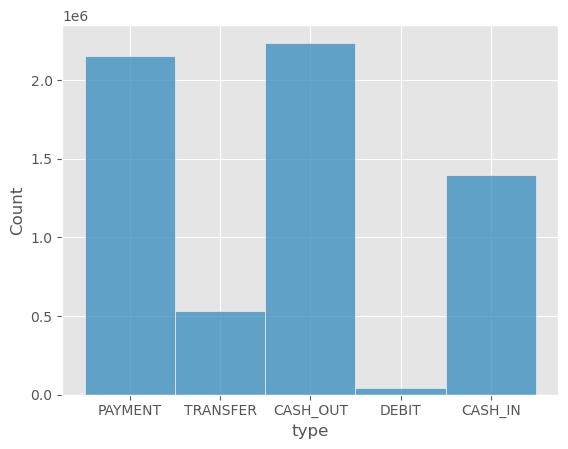

In [ ]:
sns.histplot(df.type)

<AxesSubplot:xlabel='type', ylabel='Count'>

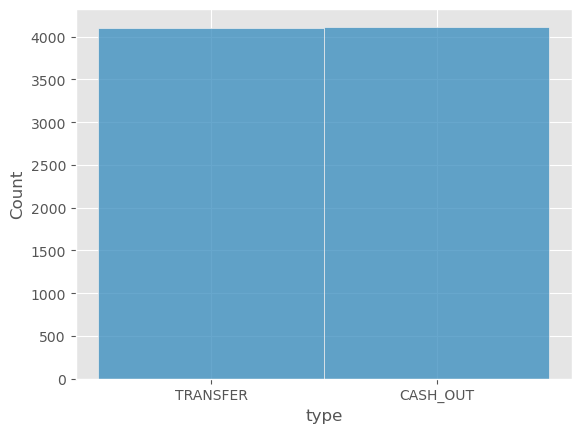

In [ ]:
sns.histplot(df.loc[df['isFraud'] == 1]['type'])

In [ ]:
len(df.loc[(df.type == 'TRANSFER') & (df.isFraud == 1)])/len(df.loc[df.type == 'TRANSFER']) ## Percentage of transfer transactions which are frauds

0.007687991758442811

In [ ]:
len(df.loc[(df.type == 'CASH_OUT') & (df.isFraud == 1)])/len(df.loc[df.type == 'CASH_OUT']) ## Percentage of cashout transactions which are frauds

0.0018395530726256983

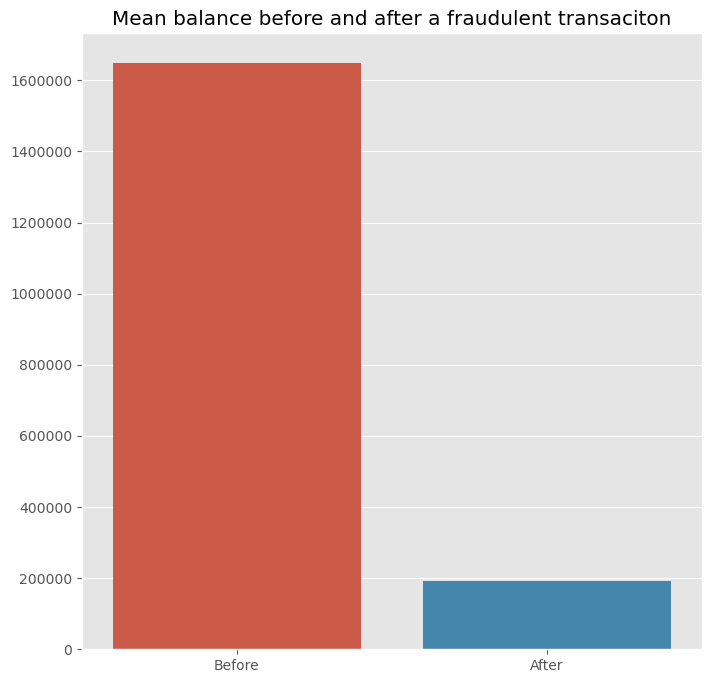

In [ ]:
plt.figure(figsize=(8,8))
k = sns.barplot(x=df.loc[(df.isFraud == 1) & (df.type != 'CASH_IN')][['oldbalanceOrig','newbalanceOrig']].mean().index, y=df.loc[(df.isFraud == 1) & (df.type != 'CASH_IN')][['oldbalanceOrig','newbalanceOrig']].mean().values)
k.set_xticklabels(['Before','After'])
plt.title('Mean balance before and after a fraudulent transaciton')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


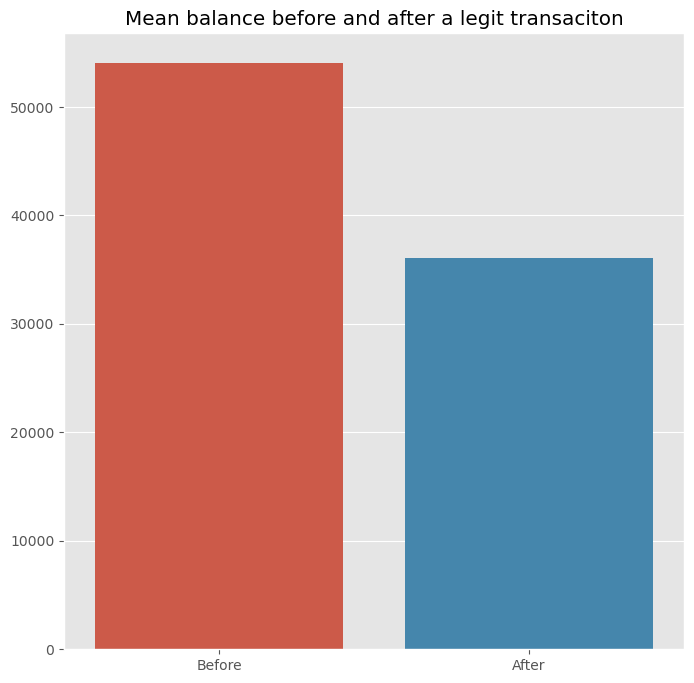

In [ ]:
plt.figure(figsize=(8,8))
k = sns.barplot(x=df.loc[(df.isFraud != 1) & (df.type != 'CASH_IN')][['oldbalanceOrig','newbalanceOrig']].mean().index, y=df.loc[(df.isFraud != 1) & (df.type != 'CASH_IN')][['oldbalanceOrig','newbalanceOrig']].mean().values)
k.set_xticklabels(['Before','After'])
plt.title('Mean balance before and after a legit transaciton')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


## Check outliers

In [ ]:
df.describe()

,amount,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,oldbalanceOrig,hour
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,179861.90,855113.67,1100701.67,1224996.40,0.00,833883.10,15.32
std,603858.23,2924048.50,3399180.11,3674128.94,0.04,2888242.67,4.32
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,13389.57,0.00,0.00,0.00,0.00,0.00,12.00
50%,74871.94,0.00,132705.66,214661.44,0.00,14208.00,16.00
75%,208721.48,144258.41,943036.71,1111909.25,0.00,107315.18,19.00
max,92445516.64,49585040.37,356015889.35,356179278.92,1.00,59585040.37,23.00


In [ ]:
df.loc[abs(stats.zscore((df['amount'])) < 4.2) &
      (abs(stats.zscore(df['newbalanceOrig'])) < 4.2) &
      (abs(stats.zscore(df['oldbalanceDest'])) < 4.2) & 
      (abs(stats.zscore(df['newbalanceDest'])) < 4.2) &
      (abs(stats.zscore(df['oldbalanceOrig'])) < 4.2)] ## Check Outliers

,type,amount,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,oldbalanceOrig,typeDest,hour
0,PAYMENT,9839.64,160296.36,0.00,0.00,0,170136.00,M,1
1,PAYMENT,1864.28,19384.72,0.00,0.00,0,21249.00,M,1
2,TRANSFER,181.00,0.00,0.00,0.00,1,181.00,C,1
3,CASH_OUT,181.00,0.00,21182.00,0.00,1,181.00,C,1
4,PAYMENT,11668.14,29885.86,0.00,0.00,0,41554.00,M,1
...,...,...,...,...,...,...,...,...,...
6362613,CASH_OUT,1258818.82,0.00,503464.50,1762283.33,1,1258818.82,C,23
6362614,TRANSFER,339682.13,0.00,0.00,0.00,1,339682.13,C,23
6362615,CASH_OUT,339682.13,0.00,0.00,339682.13,1,339682.13,C,23
6362618,TRANSFER,850002.52,0.00,0.00,0.00,1,850002.52,C,23


In [ ]:
df.describe()

,amount,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,oldbalanceOrig,hour
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,179861.90,855113.67,1100701.67,1224996.40,0.00,833883.10,15.32
std,603858.23,2924048.50,3399180.11,3674128.94,0.04,2888242.67,4.32
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,13389.57,0.00,0.00,0.00,0.00,0.00,12.00
50%,74871.94,0.00,132705.66,214661.44,0.00,14208.00,16.00
75%,208721.48,144258.41,943036.71,1111909.25,0.00,107315.18,19.00
max,92445516.64,49585040.37,356015889.35,356179278.92,1.00,59585040.37,23.00


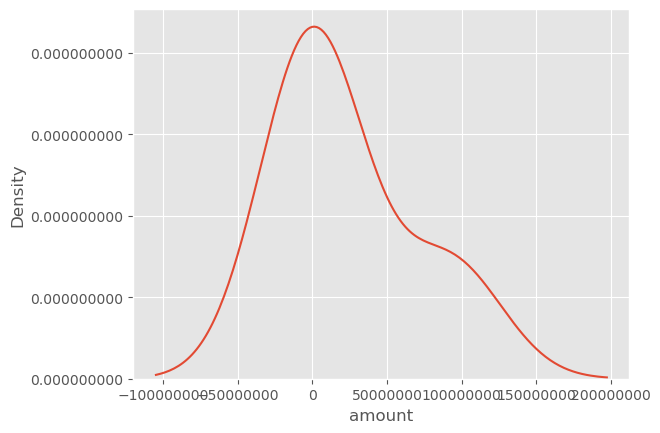

In [ ]:
sns.kdeplot(df.describe()['amount'][['25%','50%','75%','max']])
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

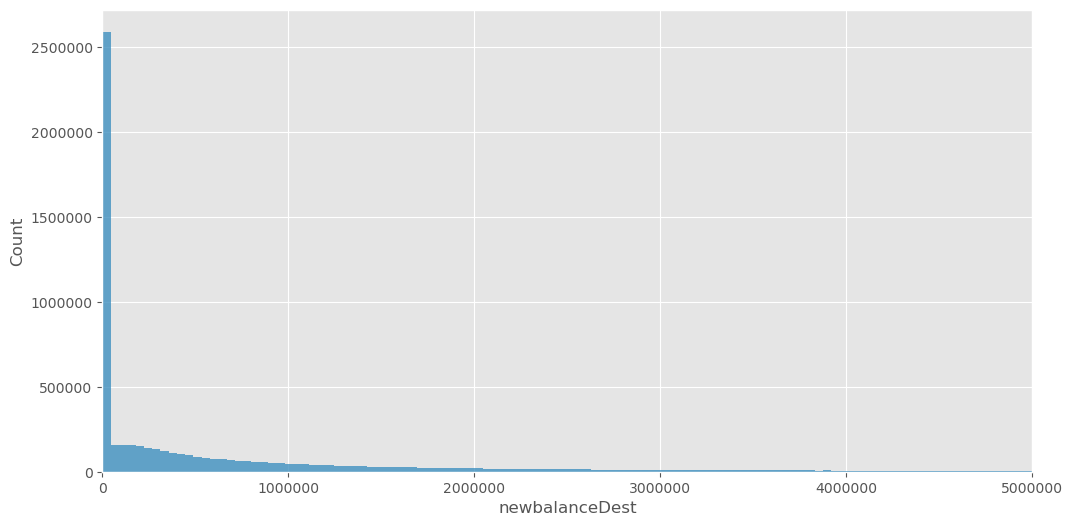

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(df['newbalanceDest'],bins=8000)
plt.ticklabel_format(style='plain', axis='x')
plt.xlim([0,5000000])
plt.ticklabel_format(style='plain', axis='y')

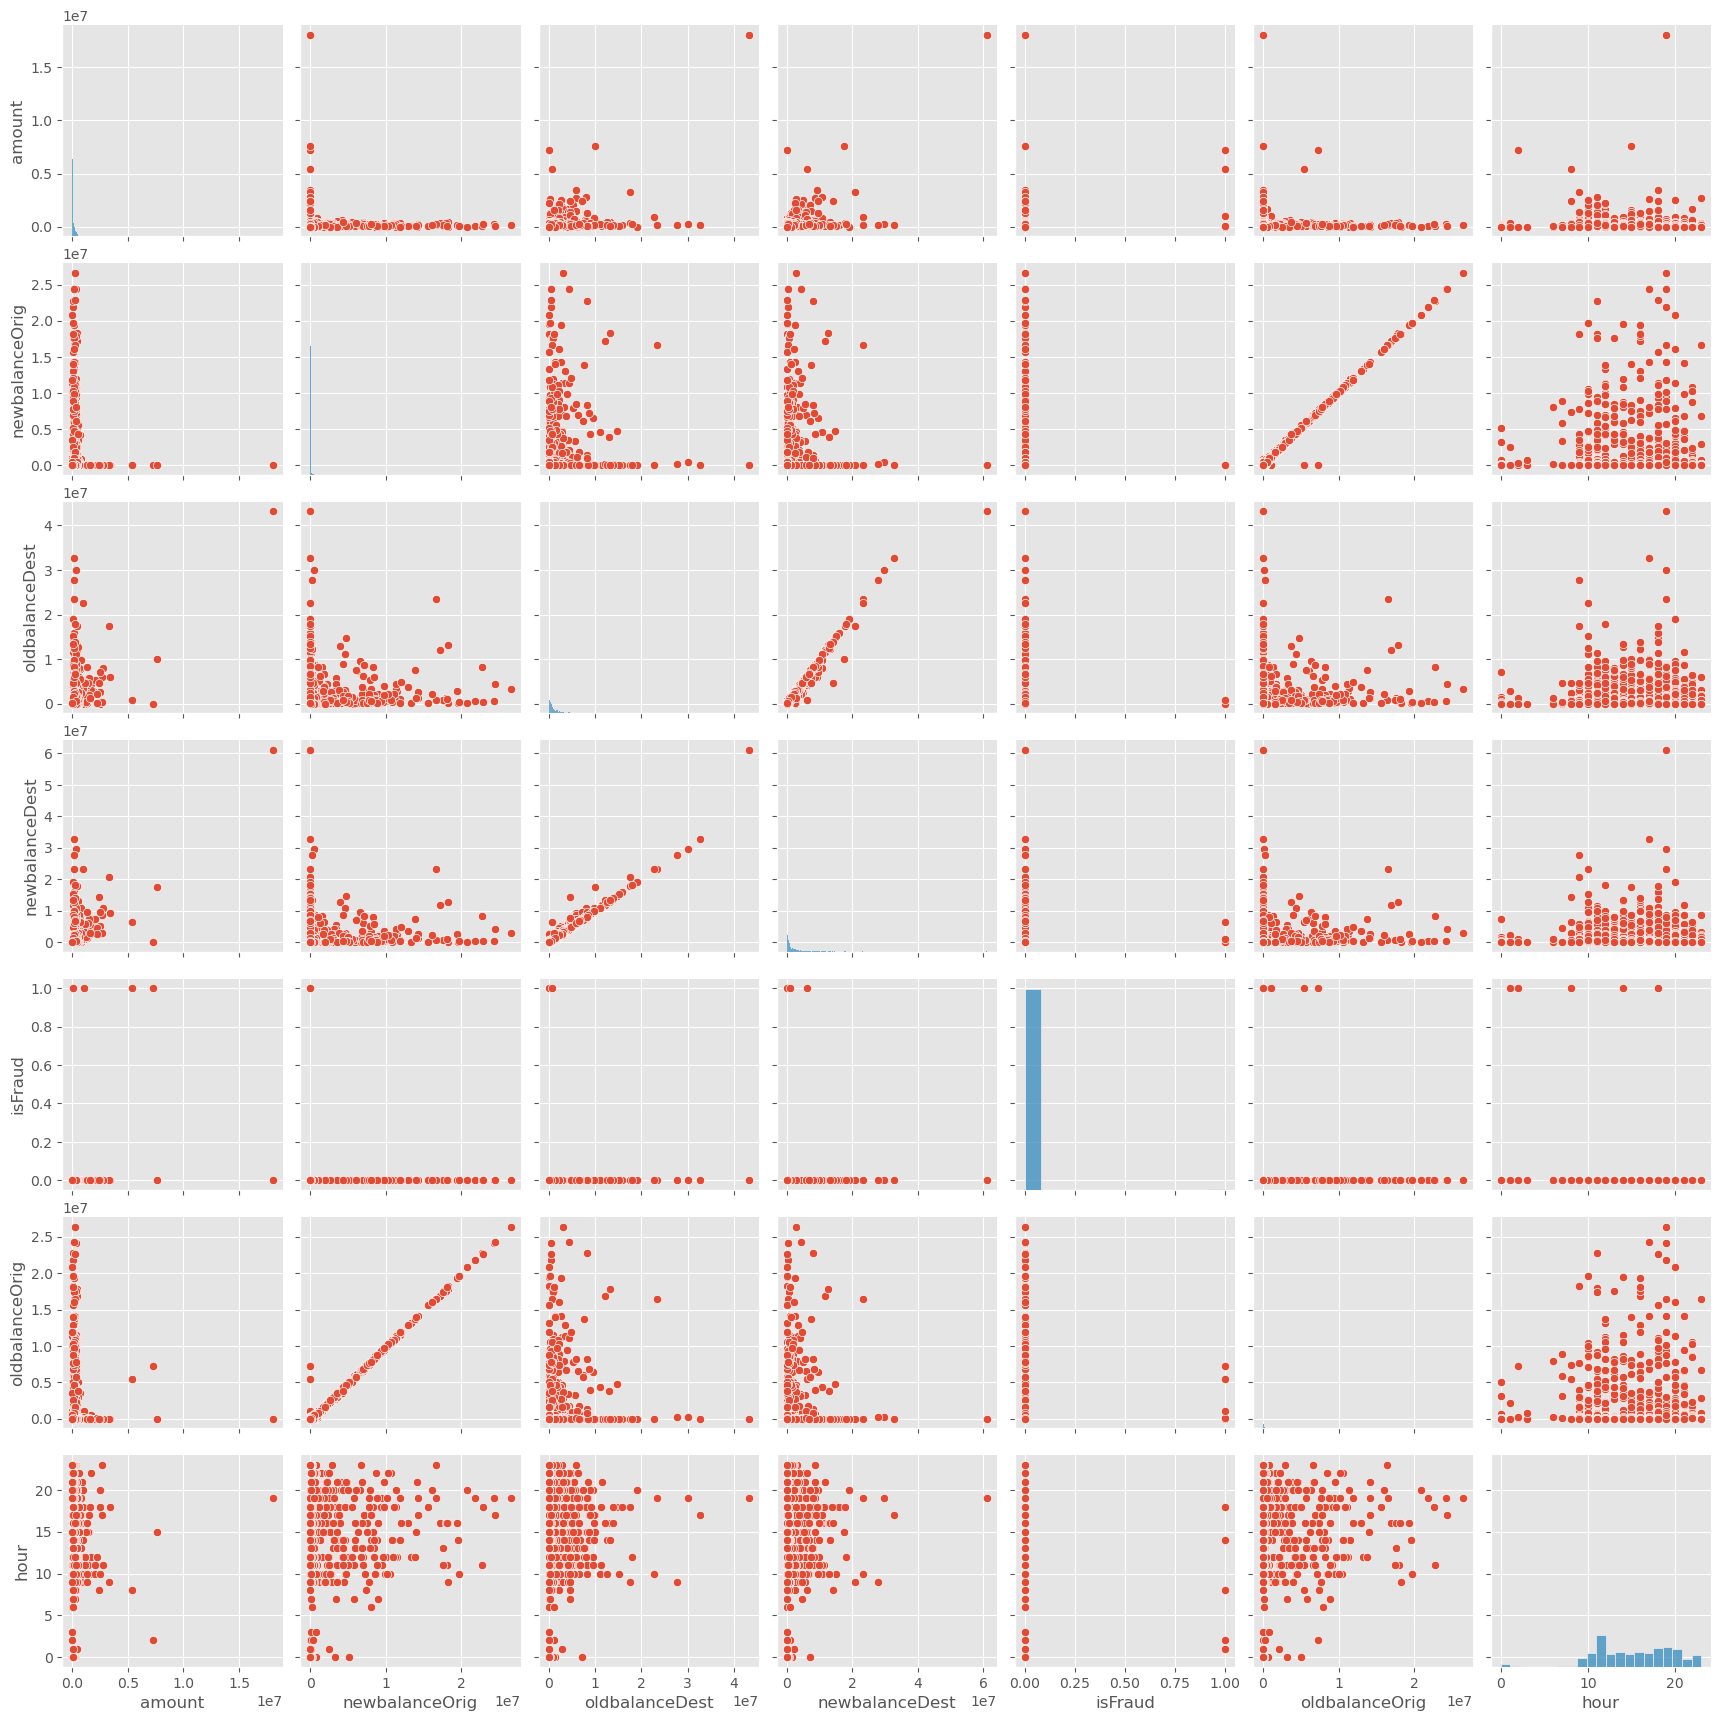

In [ ]:
sns.pairplot(df.sample(n=2000))

## Finding which classifier gives us the best results

In [ ]:
((df.isFraud.value_counts()[1]/df.isFraud.value_counts()[0]))*100000 # how many frauds is there per million tx

129.248881917699

In [ ]:
## Testing model with smaller sample to save on time
dfs = df.sample(n=200000,random_state=42)
X = dfs.drop(columns='isFraud')
y = dfs.isFraud

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
classifiers = [GradientBoostingClassifier(),SVC(),RandomForestClassifier(),XGBClassifier()]

In [ ]:
tally = []
for cl in classifiers:
    num_feat = make_column_selector(dtype_include='number')
    cat_feat = make_column_selector(dtype_include='object')

    prepro = make_column_transformer((StandardScaler(),num_feat),(OneHotEncoder(drop='if_binary',handle_unknown='ignore'),cat_feat))
    pipe = make_pipeline(prepro,cl)
    grid = GridSearchCV(estimator=pipe,param_grid={},n_jobs=-1,cv=5,scoring='recall')
    grid.fit(X_train,y_train)
    tally.append((cl,grid.best_score_))
    print(f'{cl} done!')
pd.DataFrame(tally)

GradientBoostingClassifier() done!
SVC() done!
RandomForestClassifier() done!
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) done!


,0,1
0,GradientBoostingClassifier(),0.41
1,SVC(),0.20
2,RandomForestClassifier(),0.73
3,"XGBClassifier(base_score=None, booster=None, c...",0.75


XGB and RandomForestClassifier is best. Hard to tell with that small sample size though. But we will continue with those two.

## Dummy baseline

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [ ]:
roc_auc_score(y_train,dummy.predict(X_train))

0.5

In [ ]:
f1_score(y_train,dummy.predict(X_train))

0.0

In [ ]:
recall_score(y_train,dummy.predict(X_train))

0.0

In [ ]:
precision_score(y_train,dummy.predict(X_train))

/Users/eriknelson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
dummy.score(X_train,y_train)

0.99869375

## Crossvalidating our models

In [ ]:
num_feat = make_column_selector(dtype_include='number')
cat_feat = make_column_selector(dtype_include='object')
prepro = make_column_transformer((StandardScaler(),num_feat),(OneHotEncoder(drop='if_binary',handle_unknown='ignore'),cat_feat))

In [ ]:
xgbpipe = make_pipeline(prepro,XGBClassifier(n_jobs=-1))
xgbscore = cross_val_score(xgbpipe, X_train, y_train, cv = 5,scoring='recall')

In [ ]:
rfcpipe = make_pipeline(prepro,RandomForestClassifier(n_jobs=-1))
rfcscore = cross_val_score(rfcpipe, X_train, y_train, cv = 5,scoring='recall')

In [ ]:
rfcscore

array([0.7804878 , 0.73809524, 0.69047619, 0.66666667, 0.78571429])

In [ ]:
xgbscore

array([0.80487805, 0.78571429, 0.73809524, 0.71428571, 0.76190476])

In [ ]:
scoredf = pd.DataFrame(list(zip(rfcscore, xgbscore)),columns =['rfcscore', 'xgbscore'])
scoredf.loc['mean'] = scoredf.mean()
scoredf

,rfcscore,xgbscore
0,0.78,0.80
1,0.74,0.79
2,0.69,0.74
3,0.67,0.71
4,0.79,0.76
mean,0.73,0.76


In [ ]:
## XGB WINNER

In [ ]:
xgbpipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd58fda8a30>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd58fda8a60>)])),
                ('xgbc...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
       

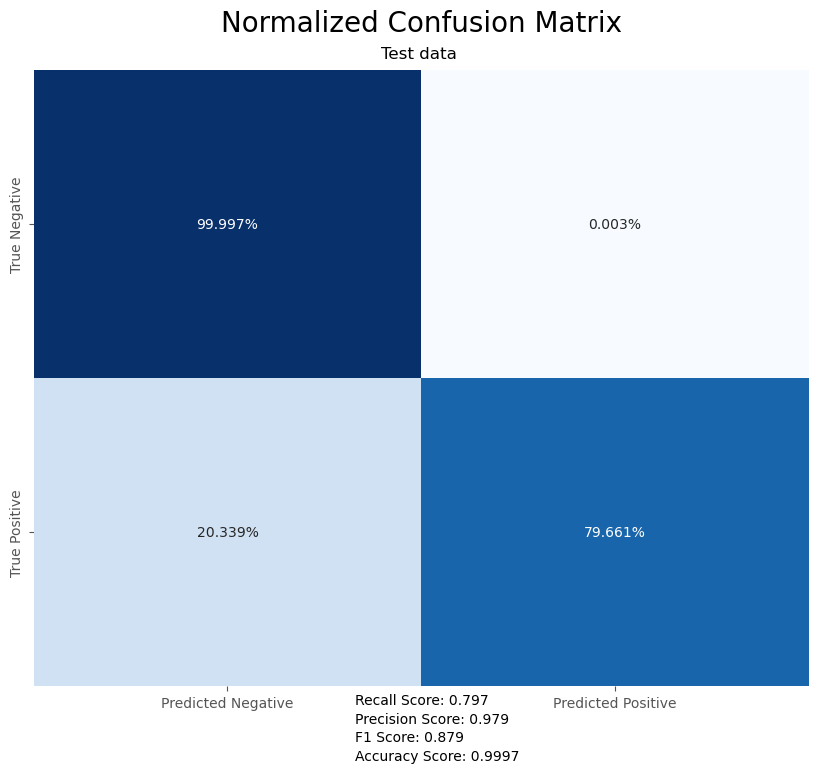

In [ ]:
y_data = y_test
X_data = X_test
type = 'Test'
plt.figure(figsize=(10,8))
x_labels = ["Predicted Negative", "Predicted Positive"]
y_labels = ["True Negative", "True Positive"]
cm = confusion_matrix(y_data,xgbpipe.predict(X_data),normalize='true')
sns.heatmap(cm,annot=True,fmt='.3%',cmap='Blues',xticklabels=x_labels, yticklabels=y_labels,cbar=False)
plt.title('Normalized Confusion Matrix',pad=28,size=20)
plt.text(0.895,-0.037,f'{type} data',size=12)
plt.text(0.83,2.06,f'Recall Score: {round(recall_score(y_data,xgbpipe.predict(X_data)),3)}')
plt.text(0.83,2.12,f'Precision Score: {round(precision_score(y_data,xgbpipe.predict(X_data)),3)}')
plt.text(0.83,2.18,f'F1 Score: {round(f1_score(y_data,xgbpipe.predict(X_data)),3)}')
plt.text(0.83,2.24,f'Accuracy Score: {round(xgbpipe.score(X_data,y_data),4)}')
plt.show()